# **NOTE for Colab Users**

# **Do NOT write directly in this file—your work might be lost!**

# **Always make a copy before you start.**

How to make a copy

1. Click "File" in the top left.
> *If you can’t find the header (like “File” or "Runtime"), click the “v” mark at the top right to show it.*

2. "Save a copy in Drive"

3. Change the copied file’s name to “YOURNAMEs\_FileName.ipynb”.
> Ex: If your name is Olivia : Olivias_FileName.ipynb

4. Set your runtime to **CPU**. T4 GPU resets your session more often than CPU.<br>
So, it’s best to use the CPU runtime unless you need GPU for training.<br>
Check out this [Video](https://youtu.be/XRmI-qRiFFw).<br>

> If you switch the runtime halfway, you have to rerun all cells from the start.<br>
> Please pick your runtime before you begin.<br>
> *Rerunning cells: Click “Runtime” (top left) → Then click “Run before”.*<br>

---

* Check marks (✅) won’t be saved. If you reload the page with Chrome’s refresh button, they’ll disappear.<br>
If you want to pause and come back later, just add a text cell and write something like “SO FAR DONE.”

---

* In Colab, **previous outputs reset every 30 to 90 minutes**.<br>
  Because of this, errors like `~~ is not defined` will happen **very often**.

  🔁 What to do when you get an `~~is not defined` error
  1. First, make sure your variable is spelled right.<br>
  2. If it’s spelled right but you still see the error, **click the cell you want to restart**.<br>
  3. Go to “Runtime” (top left) → Click “Run before”.<br>
    → This will **re-run all previous cells**.
  4. Run the cell again.

  If you still see the error after these steps,<br>
  there might be a basic mistake in your TODO answers from earlier cells.<br>
  Please check if your answer is right.<br>
  Or ask ChatGPT or another coding assistant for help.

# **Preparation**

This section only loads content from earlier chapters.<br>
Just run the code—you don’t need to read it.<br>
Feel free to skip ahead.<br>

In [ ]:
# Donwload the file
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# Load the file called input.text that you just downloaded in utf-8.
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# A Function to Display Tensors Nicely (Feel Free to Skip This)
import torch
import torch.nn as nn

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("name", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """

    # Determine tensor and name from arguments
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Convert Tensor to List
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """Formatting a recursively nested list and returning a string"""
        # If the contents are lists, then re-return
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # For numerical lists
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # Formatted string (bar brackets on outermost frames are removed)
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # Result output
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Define an embedded table for vocabulary number x number of embedding dimensions
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # Get the embedded vector corresponding to the input index
        return self.token_embedding_table.forward(input_indices)

# Defining a Position Embedded Module
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length, embedding_dim):
        super().__init__()
        # Location embedding layer
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        sequence_length = input_indices.shape[1]  # Get sequence length
        position_indices = torch.arange(sequence_length, device=input_indices.device)  # Position index generation
        position_embeddings = self.position_embedding_layer(position_indices)  # Position embedding
        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # Embedded layer for each token
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)

    def forward(self, input_indices):
        # Get token embedding
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # Get location embedding
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # Adding token embedding and position embedding
        embeddings = token_embeddings + position_embeddings
        return embeddings

zsh:1: command not found: wget


# **Chapter 5: LayerNorm**

### **Section 1: forward**

Let's recall the **Token Embedding + Position Embedding** for the 8-character string `Let's he` embedded into 8 dimensions from the last chapter.

In [4]:
# Configuration class that stores model settings
class ModelConfig:
    batch_size = 1  # Number of data to process at a time (batch size)
    input_sequence_length = 8  # Length of input data (sequence length)
    embedding_dim = 8  # Embedded layer size (number of dimensions of feature vector)

In [5]:
import torch
import torch.nn as nn
torch.manual_seed(1337)

# Creating a ModelConfig instance. No configuration parameters (constructors).
config = ModelConfig()

# Creating an EmbeddingModule instance. The configuration parameters are the number of vocabulary and the config instance.
embedding_module = EmbeddingModule(vocab_size = 65, config = config)

# Compatible with Let's he. (Batch size, token length) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
embeddings = embedding_module.forward(sample_input_tokens) # TODO: Instance.Method(Argument). Check the previous or earlier chapters for a hint.
print_formatted_tensor(embeddings)

Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.64,  -1.51,   3.40,   0.56,   1.41,   0.14,  -1.12,   0.14],
           [ -0.31,  -1.02,   0.84,  -0.26,  -2.42,  -0.19,   1.52,  -1.75],
           [ -0.99,  -0.21,  -1.53,  -0.83,   1.61,   1.06,  -0.80,  -0.09],
           [ -1.39,  -0.10,   1.01,  -1.41,  -0.06,   2.02,  -1.02,  -0.94],
           [ -1.90,   0.03,  -0.12,  -0.51,   0.70,   0.68,   0.84,  -0.06],
           [ -0.06,   1.28,  -1.05,   0.31,   1.13,  -0.45,  -0.31,  -0.93],
           [ -1.77,  -0.58,   1.94,   1.21,  -0.22,   1.55,  -1.32,   0.62],
           [ -0.82,   0.67,   0.26,  -1.64,   0.13,  -1.37,   1.46,   1.19]
         ]
       ])


**PostNorm and PreNorm**  
<br>  

The embeddings from **Token Embedding + Position Embedding** get normalized before applying the Attention mechanism.  

In the first Transformer paper, normalization was done **after** applying Attention. This is called **PostNorm**.  

But to keep input data stable, it became common to normalize the input **before** Attention.

This is called **PreNorm**.  

This tutorial also uses PreNorm.  
<br>


**Layer Normalization for Token Embedding + Position Embedding**<br>

Layer norm runs per token along the embedding dims.
It computes each token's mean and variance across the embedding dims.
Then it shifts the tensor so its mean is 0 and its variance is 1.

The input tensor shape is

(batch size, token length, embedding size)

Normalization happens across the embedding size dims, i.e. `dim=-1`(the last dim).

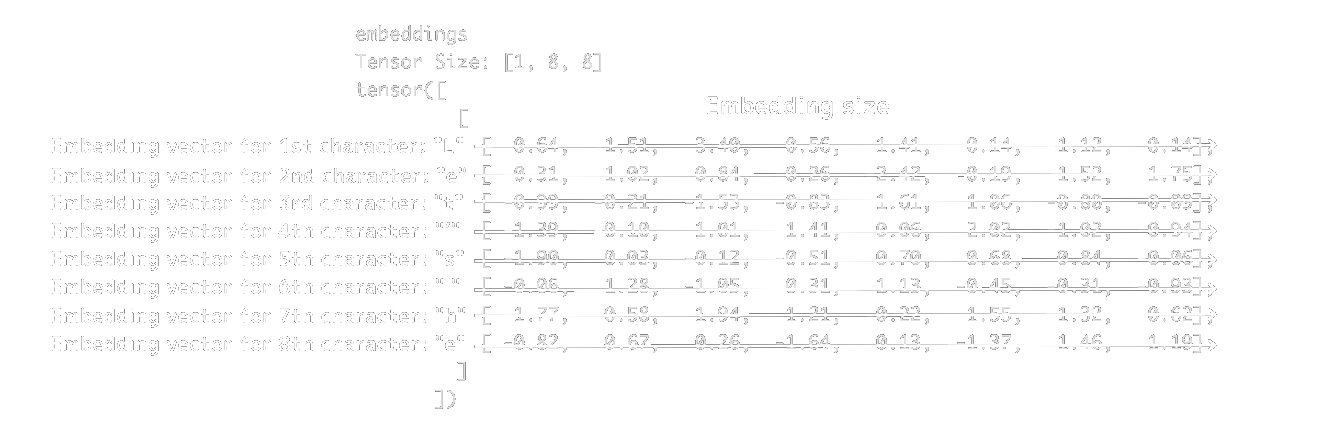

```python
Function: torch.mean
Arguments:
  - embeddings: input tensor   shape: (batch size, token length, embedding size) = (1, 8, 8)
  - dim=-1: compute mean along dimension -1 (embedding size). 2 is also fine.
  - keepdim=True: keep output dimensions (to avoid shape breaking)
```
- Calculate the **mean of tensor `embeddings` along the last dimension -1 (embedding size)** and return a new tensor.  
- Using `keepdim=True` keeps the output’s shape as `(1, 8, 1)`, preserving the original shape info. <br>
 If set to `keepdim=False`, the output shape becomes `(1, 8)`, which causes trouble in later steps.

In [6]:
mean = torch.mean(embeddings, dim=-1, keepdim=True) # TODO: Function (argument)
print_formatted_tensor("mu tensor", mean)

mu tensor
Tensor Size: [1, 8, 1]
tensor([
         [
           [  0.46],
           [ -0.45],
           [ -0.22],
           [ -0.24],
           [ -0.04],
           [ -0.01],
           [  0.18],
           [ -0.02]
         ]
       ])


```python
Function: torch.var
Arguments:
  - embeddings: input tensor with shape (batch size, token length, embedding size) = (1, 8, 8)
  - dim=-1: calculate variance along the last dimension -1 (embedding size)
  - keepdim=True: keep output dimensions (to preserve shape)
  - unbiased=False: divides by N (default is `True`, divides by N-1).
```
- Calculates the **variance along the last dimension -1 (embedding size)** of the tensor `embeddings` and returns a new tensor.
- Setting `keepdim=True` makes the output variance tensor have shape `(1, 8, 1)`, keeping the original shape info. <br>
If `keepdim=False`, the variance tensor shape becomes `(1, 8)`, which causes trouble in later calculations.
- `unbiased = False` divides by N. `unbiased = True` divides by N-1.


In [21]:
var = torch.var(embeddings, dim=-1, keepdim=True, unbiased=False) # TODO: Function (argument)
print_formatted_tensor("variation tensor\n", var)

variation tensor

Tensor Size: [1, 8, 1]
tensor([
         [
           [  2.02],
           [  1.45],
           [  1.00],
           [  1.31],
           [  0.69],
           [  0.66],
           [  1.63],
           [  1.16]
         ]
       ])


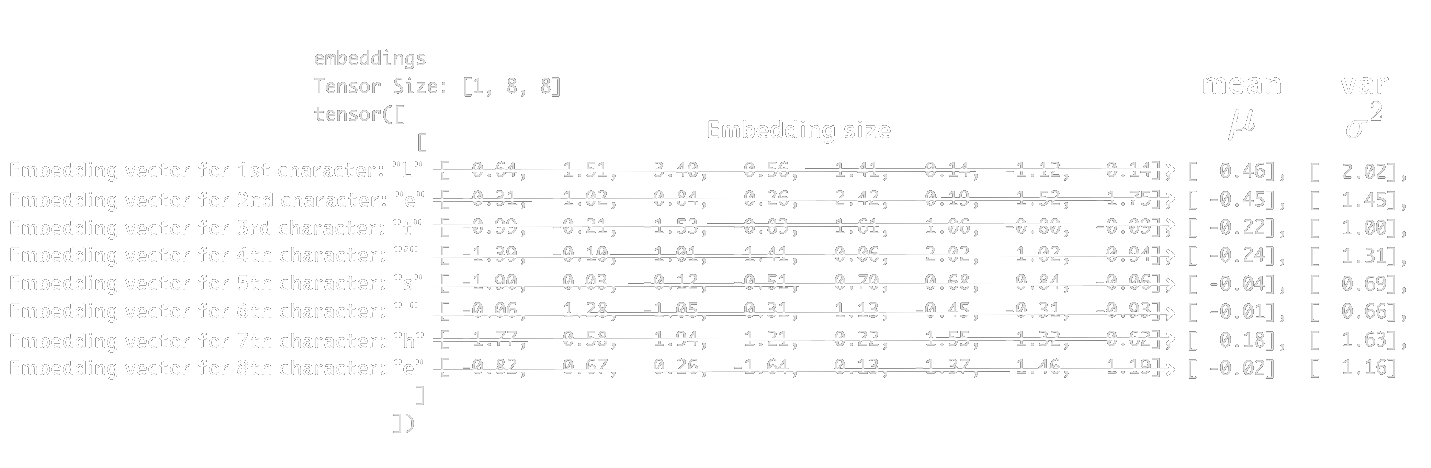

**Standard Normalization**

The whole process is written as:

$$
\text{Normalized value} = \frac{{x_i} - \mu}{\sqrt{(\sigma^2 + \epsilon)}}
$$

Inside the root is $(\sigma^2 + \epsilon)$.

1. Subtract the mean (Centering: ${x_i} - \mu$)

   * Shift the data so the center is 0, based on the average value.

2. Divide by the standard deviation (Scaling: $\sqrt{(\sigma^2 + \epsilon)}$)

   * Take the square root of the variance plus a small value.
   * The small value $\epsilon$ prevents division by zero errors.
   * Set $\epsilon = 10~^{-5}$.

PyTorch supports flexible broadcasting,<br>
so you don’t need to use operations like `.unsqueeze()` on `eps` to match shapes.<br>
Just a quick reminder, since we covered this in earlier chapters—<br>
broadcasting lets you work with different-sized tensors easily.

In [8]:
eps = 1e-5 # TODO: The -n power of 10 can be displayed as 1e-n
hat = (embeddings - mean) / torch.sqrt(var + eps) # TODO: Implement the standard normalization formula. Tip: Use torch.sqrt. x is the variable `embeddings`.
print_formatted_tensor("hat", hat)

hat
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])


**`Check Point`** <label><input type="checkbox"> ← Check this box if the result above matches the answer below<label>

```
hat
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])
```

Let's sum up the first token across emebedding size, and calculate the mean.

In [9]:
sum_hat_token0 = 0.13 + (-1.39) + (2.07) + 0.07 + 0.67 + (-0.22) + (-1.11) + (-0.22)
print("sum_hat_dim0", round(sum_hat_token0, 2))

sum_hat_dim0 0.0


In [10]:
mean_hat_dim0 = sum_hat_token0 / 8
print("mean_hat_dim0", round(mean_hat_dim0, 2))

mean_hat_dim0 0.0


Calculate the mean and var for the normalized tensor `hat` for each embedding dimension.

```python
Function: torch.mean
Arguments: THINK_FOR_YOURSELF
```

In [11]:
mean_hat = torch.mean(hat, dim=-1, keepdim=True) # TODO: Calculate the mean for the normalized tensor `hat`.
print_formatted_tensor("mean_hat", mean_hat)

mean_hat
Tensor Size: [1, 8, 1]
tensor([
         [
           [  0.00],
           [ -0.00],
           [  0.00],
           [  0.00],
           [  0.00],
           [ -0.00],
           [  0.00],
           [  0.00]
         ]
       ])


```python
Function: torch.var
Arguments: THINK_FOR_YOURSELF
```

In [12]:
var_hat = torch.var(hat, dim=-1, keepdim=True, unbiased=False) # TODO: Calculate the variance for the normalized tensor `hat`.
print_formatted_tensor("var_hat", var_hat)

var_hat
Tensor Size: [1, 8, 1]
tensor([
         [
           [  1.00],
           [  1.00],
           [  1.00],
           [  1.00],
           [  1.00],
           [  1.00],
           [  1.00],
           [  1.00]
         ]
       ])


**Scaling and Shifting**

Standard normalization just sets the mean to 0 and variance to 1.

But data can’t always fit a standard normal distribution... right?

So, it lets us represent a normal distribution with mean (β) and variance ($\gamma^2$).

This happens through scaling (γ) and shifting (β) with this operation. (Same idea as VAE)<br>
<br>

$$
{norm\_embeddings} = \gamma \hat~{x} + \beta
$$

<br>
At first, scaling (γ) is set to 1 and shifting (β) to 0 to match standard normalization. So it starts as a standard normal.<br>
Then, as training goes on, γ and β change.


In [13]:
token_length = 8
gammma = torch.ones(token_length) # TODO: torch.ones(token_length)
beta = torch.zeros(token_length) # TODO: torch.zeros(token_length)

print_formatted_tensor("gammma", gammma)
print_formatted_tensor("Beta", beta)

gammma
Tensor Size: [8]
tensor([
         1.00,   1.00,   1.00,   1.00,   1.00,   1.00,   1.00,   1.00
       ])
Beta
Tensor Size: [8]
tensor([
         0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00
       ])


$$
{norm\_embeddings} = \gamma \hat~{x} + \beta
$$

In [14]:
norm_embeddings = gammma * hat + beta # TODO: Implement the above formula. In Pytorch, the presence or absence of batch sizes is often flexibly calculated.
print_formatted_tensor("norm_embeddings", norm_embeddings)

norm_embeddings
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])


At first, the scale (γ) is set to 1 and the shift (β) to 0 to match standard normalization.

So, `hat` and `norm_embeddings` are the same in the beggining.<br>

**`Check Point`** <label><input type="checkbox"> ← Check this box if the above result matches the answer below<label>

```
norm_embeddings
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])
```

### **Section 2: Define a Class**

🔘 **Options**: There may be extra options you don't need.

`np.ones`  `self.eps`  `self.norm_dim`  `mean`  `var`  `torch.sqrt`  `hat`

In [15]:
class LayerNorm(nn.Module):  # Inherit nn.Module here
    def __init__(self, token_length, eps=1e-5, norm_dim=-1):
        super().__init__()
        self.eps = eps
        self.norm_dim = norm_dim

        # Register gamma and beta as nn.Parameter for use on both CPU and CUDA
        self.gamma = nn.Parameter(torch.ones(token_length))
        self.beta = nn.Parameter(torch.zeros(token_length))

    def forward(self, x):
        mean = torch.mean(x, dim=self.norm_dim, keepdim=True)
        var = torch.var(x, dim=self.norm_dim, keepdim=True, unbiased=False)
        hat = (x - mean) / torch.sqrt(var + self.eps)
        output =  self.gamma * hat + self.beta
        return output

In [16]:
"""
class LayerNorm(nn.Module):  # Inherit nn.Module here
    def __init__(self, token_length, eps=1e-5, norm_dim=-1):
        super().__init__()
        self.eps = eps
        self.norm_dim = norm_dim

        # Register gamma and beta as nn.Parameter for use on both CPU and CUDA
        self.gamma = nn.Parameter(torch.ones(token_length))
        self.beta = nn.Parameter(torch.zeros(token_length))

    def forward(self, x):
        mean = torch.mean(x, dim=self.norm_dim, keepdim=True)
        var = torch.var(x, dim=__________, keepdim=True, unbiased=False)
        normalized_x = (x - ____) / torch.sqrt(___ + self.eps)
        output =  self.gamma * ___ + self.beta
        return output
"""

'\nclass LayerNorm(nn.Module):  # Inherit nn.Module here\n    def __init__(self, token_length, eps=1e-5, norm_dim=-1):\n        super().__init__()\n        self.eps = eps\n        self.norm_dim = norm_dim\n\n        # Register gamma and beta as nn.Parameter for use on both CPU and CUDA\n        self.gamma = nn.Parameter(torch.ones(token_length))\n        self.beta = nn.Parameter(torch.zeros(token_length))\n\n    def forward(self, x):\n        mean = torch.mean(x, dim=self.norm_dim, keepdim=True)\n        var = torch.var(x, dim=__________, keepdim=True, unbiased=False)\n        normalized_x = (x - ____) / torch.sqrt(___ + self.eps)\n        output =  self.gamma * ___ + self.beta\n        return output\n'

<details>
<summary>Click here to show/hide the answer</summary>

```python
class LayerNorm(nn.Module):  # Inherit nn.Module here
    def __init__(self, token_length, eps=1e-5, norm_dim=-1):
        super().__init__()
        self.eps = eps
        self.norm_dim = norm_dim

        # Register gamma and beta as nn.Parameter for use on both CPU and CUDA
        self.gamma = nn.Parameter(torch.ones(token_length))
        self.beta = nn.Parameter(torch.zeros(token_length))

    def forward(self, x):
        mean = torch.mean(x, dim=self.norm_dim, keepdim=True)
        var = torch.var(x, dim=self.norm_dim, keepdim=True, unbiased=False)
        hat = (x - mean) / torch.sqrt(var + self.eps)
        output =  self.gamma * hat + self.beta
        return output
```

In [17]:
layer_norm = LayerNorm(token_length = config.input_sequence_length)
norm_embeddings = layer_norm.forward(embeddings) # TODO: Instance.Method(Argument). Argument is `embeddings`
print_formatted_tensor("norm_embeddings", norm_embeddings)

norm_embeddings
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])


**`Check Point`** <label><input type="checkbox"> ← Check this box if the result above matches the answer below<label>

```
norm_embeddings
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])
```

In [18]:
layer_norm = nn.LayerNorm(config.embedding_dim)
norm_embeddings = layer_norm.forward(embeddings) # TODO: Instance.Method(Argument). Argument is `embeddings`
print_formatted_tensor("norm_embeddings", norm_embeddings)

norm_embeddings
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])


**`Check Point`** <label><input type="checkbox"> ← Check this box if the result above matches the answer below<label>

```
norm_embeddings
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])
```

Ah, I am afraid but Pytorch has `nn.LayerNorm` built in.

Using the built-in one is faster and less error-prone.

```python
instance: layer_norm = nn.LayerNorm(input_dim)
input_dim: config.embedding_dim # Not the input token length
```

* `nn.LayerNorm` is a module for **Layer Normalization**.
* The `config.embedding_dim` sets the normalized dimension (the embedding size).<br>
  Note: `nn.LayerNorm` figures out token length internally, so you don’t need to pass it.

In [19]:
# Create a Layer Normalization instance
layer_norm = nn.LayerNorm(config.embedding_dim) # TODO: assign nn.LayerNorm(input_dim)
norm_embeddings = layer_norm.forward(embeddings)
print_formatted_tensor("norm_embeddings", norm_embeddings)

norm_embeddings
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])


**`Check Point`** <label><input type="checkbox"> ← Check this box if the result above matches the answer below<label>

```
norm_embeddings
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.13,  -1.39,   2.07,   0.07,   0.67,  -0.22,  -1.11,  -0.22],
           [  0.12,  -0.48,   1.07,   0.15,  -1.64,   0.22,   1.64,  -1.08],
           [ -0.77,   0.01,  -1.30,  -0.61,   1.83,   1.28,  -0.57,   0.13],
           [ -1.00,   0.12,   1.09,  -1.03,   0.15,   1.97,  -0.68,  -0.61],
           [ -2.24,   0.08,  -0.09,  -0.56,   0.89,   0.87,   1.06,  -0.02],
           [ -0.06,   1.59,  -1.28,   0.40,   1.40,  -0.54,  -0.37,  -1.13],
           [ -1.53,  -0.60,   1.38,   0.81,  -0.32,   1.08,  -1.18,   0.35],
           [ -0.74,   0.63,   0.26,  -1.50,   0.13,  -1.26,   1.37,   1.12]
         ]
       ])
```

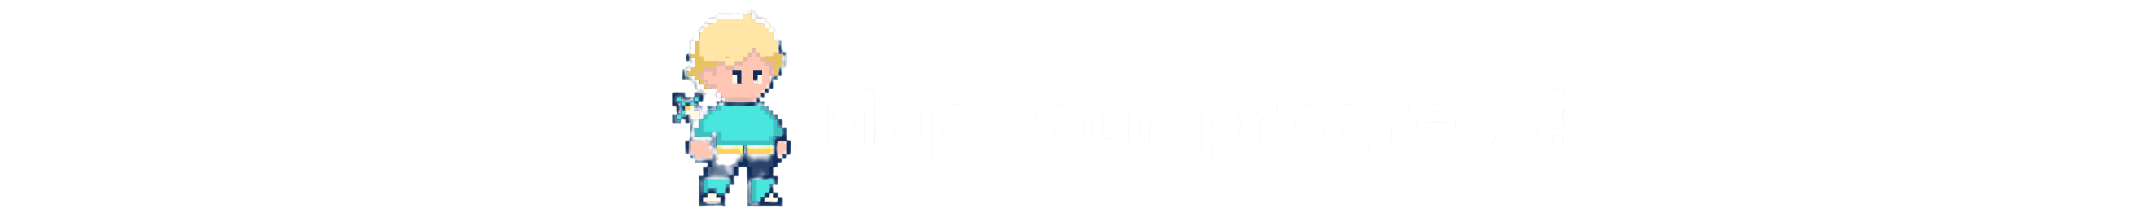

**`Chapter 5: Layer Normalization`** <label><input type="checkbox"> Mark as Done</label>